# Imports

This step is for importing all the various libraries necessary for our modeling.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn import svm
from sklearn.multiclass import OutputCodeClassifier, OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

# Helper Functions
The various helper functions used in the modeling processes.

In [3]:
# Helper function to create a ROC curve plot
def plot_roc_curves(y_test, y_prob, classes, title):

    # Binarize the target variable for ROC curve computation
    y_test_binary = preprocessing.label_binarize(y_test, classes=classes)

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Configure plot
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [4]:
# Helper function to print out classification report and confusion matrix
def print_full_report(y_test, y_pred, classes, model_name):
    print(f"\nReport for Model: {model_name}")
    
    print(f"\nClassification Report:")
    # Compute and print classification report
    print(classification_report(y_test, y_pred, target_names=classes, zero_division=0.0))

    # Compute and print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    print(cm_df)


In [5]:
# Helper function to apply PCA for dimensionality reduction
def pca_features(X, n_components=10, return_pca_model=False, random_state=42):
    # Initialize PCA
    pca = PCA(n_components=n_components, random_state=random_state)

    # Fit PCA on the dataset and transform it
    X_transformed = pca.fit_transform(X)

    # Convert the transformed data back to a DataFrame
    X_transformed = pd.DataFrame(X_transformed, index=X.index, columns=[f'pc_{i+1}' for i in range(n_components)])

    if return_pca_model:
        return X_transformed, pca
    return X_transformed

In [6]:
# Helper function to apply MDS for dimensionality reduction
def mds_features(X, n_components=2, return_mds_model=False, random_state=42):
    # Initialize MDS
    mds = MDS(n_components=n_components, random_state=random_state, dissimilarity='euclidean', n_jobs=-1)

    # Fit MDS on the dataset and transform it
    X_transformed = mds.fit_transform(X)

    # Convert the transformed data back to a DataFrame
    X_transformed = pd.DataFrame(X_transformed, index=X.index, columns=[f'mds_{i+1}' for i in range(n_components)])

    if return_mds_model:
        return X_transformed, mds
    return X_transformed

In [7]:
# Helper function to perform stratified resampling
def stratified_resample(X, y, n_samples, random_state=42):
    # Combine X and y into a single DataFrame for easier handling
    data = pd.concat([X, pd.Series(y, name="target")], axis=1)

    # Calculate the number of samples per class
    unique_classes = data["target"].unique()
    n_classes = len(unique_classes)
    samples_per_class = max(1, n_samples // n_classes)  # Ensure at least 1 sample per class

    # Perform stratified resampling
    resampled_data = []
    for class_label in unique_classes:
        # Filter data for the current class
        class_data = data[data["target"] == class_label]

        # Resample the current class
        class_resampled = resample(
            class_data,
            replace=True if len(class_data) < samples_per_class else False,  # Allow replacement if not enough samples
            n_samples=samples_per_class,
            random_state=random_state
        )

        # Append the resampled data for this class
        resampled_data.append(class_resampled)

    # Combine all resampled data
    resampled_data = pd.concat(resampled_data)

    # Shuffle the combined dataset
    resampled_data = resampled_data.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Separate features (X) and target (y)
    X_resampled = resampled_data.drop(columns=["target"])
    y_resampled = resampled_data["target"]

    return X_resampled, y_resampled

# Preprocessing

In this step we load in the data and do the nessesary preprocessing steps like standardization of the data, creating the necessary dummy variables for categorical predictors, and split out the training and testing populations.

In [8]:
# Load cleaned data from eda step
file_path = "../data/cleaned_diabetes_health_indicators_dataset.csv"
df = pd.read_csv(file_path)

In [9]:
# Preprocessing of the data

# Numerical Predictors:
    # BMI
    # MentHlth
    # PhysHlth
    # Age

# Categorical Predictors:
    # HighBP
    # HighChol
    # CholCheck
    # Smoker
    # Stroke
    # HeartDiseaseorAttack
    # PhysActivity
    # Fruits
    # Veggies
    # HvyAlcoholConsump
    # AnyHealthcare
    # NoDocbcCost
    # GenHlth
    # DiffWalk
    # Sex
    # Education
    # Income

# Target:
    # Diabetes_012

# Standardize Data
dependent_column = ["Diabetes_012"]
numerical_predictor_columns = ["BMI", "MentHlth", "PhysHlth", "Age"]

# Find Z-score of Numerical Predictors
Z_train = preprocessing.scale(df[numerical_predictor_columns])
Z_train = pd.DataFrame(Z_train, columns=numerical_predictor_columns)

# Create dummy vars
dummy_HighBP = pd.get_dummies(df["HighBP"], drop_first=True)
dummy_HighBP.columns = ["HighBP"]
dummy_HighChol = pd.get_dummies(df["HighChol"], drop_first=True)
dummy_HighChol.columns = ["HighChol"]
dummy_CholCheck = pd.get_dummies(df["CholCheck"], drop_first=True)
dummy_CholCheck.columns = ["CholCheck"]
dummy_Smoker = pd.get_dummies(df["Smoker"] , drop_first=True)
dummy_Smoker.columns = ["Smoker"]
dummy_Stroke = pd.get_dummies(df["Stroke"] , drop_first=True)
dummy_Stroke.columns = ["Stroke"]
dummy_HeartDiseaseorAttack = pd.get_dummies(df["HeartDiseaseorAttack"] , drop_first=True)
dummy_HeartDiseaseorAttack.columns = ["HeartDiseaseOrAttack"]
dummy_PhysActivity = pd.get_dummies(df["PhysActivity"] , drop_first=True)
dummy_PhysActivity.columns = ["PhysActivity"]
dummy_Fruits = pd.get_dummies(df["Fruits"] , drop_first=True)
dummy_Fruits.columns = ["Fruits"]
dummy_Veggies = pd.get_dummies(df["Veggies"] , drop_first=True)
dummy_Veggies.columns = ["Veggies"]
dummy_HvyAlcoholConsump = pd.get_dummies(df["HvyAlcoholConsump"] , drop_first=True)
dummy_HvyAlcoholConsump.columns = ["HvyAlcoholConsump"]
dummy_AnyHealthcare = pd.get_dummies(df["AnyHealthcare"] , drop_first=True)
dummy_AnyHealthcare.columns = ["AnyHealthcare"]
dummy_NoDocbcCost = pd.get_dummies(df["NoDocbcCost"] , drop_first=True)
dummy_NoDocbcCost.columns = ["NoDocbcCost"]
dummy_GenHlth = pd.get_dummies(df["GenHlth"] , drop_first=True)
dummy_GenHlth.columns = ["GenHlth2", "GenHlth3", "GenHlth4", "GenHlth5"]
dummy_DiffWalk = pd.get_dummies(df["DiffWalk"] , drop_first=True)
dummy_DiffWalk.columns = ["DiffWalk"]
dummy_Sex = pd.get_dummies(df["Sex"] , drop_first=True)
dummy_Sex.columns = ["Sex"]
dummy_Education = pd.get_dummies(df["Education"] , drop_first=True)
dummy_Education.columns = ["Education2", "Education3", "Education4", "Education5", "Education6"]
dummy_Income = pd.get_dummies(df["Income"] , drop_first=True)
dummy_Income.columns = ["Income2", "Income3", "Income4", "Income5", "Income6", "Income7", "Income8"]

# Concatenate the standardized numerical features with the dummy vars
X = pd.concat([Z_train, dummy_HighBP, dummy_HighChol, dummy_CholCheck, dummy_Smoker, dummy_Stroke, dummy_HeartDiseaseorAttack,
                     dummy_PhysActivity, dummy_Fruits, dummy_Veggies, dummy_HvyAlcoholConsump, dummy_AnyHealthcare, dummy_NoDocbcCost,
                    dummy_GenHlth, dummy_DiffWalk, dummy_Sex, dummy_Education, dummy_Income], axis=1)

y = df[dependent_column]

# Do this to avoid warnings
y = y.values.ravel()

# Binarize the target variable for multi-class classification in Linear SVM
yBinary = preprocessing.label_binarize(y, classes=[0, 1, 2])

X_PCA = pca_features(X, n_components=5, return_pca_model=False, random_state=42)
#X_MDS = mds_features(X, n_components=5, return_mds_model=False, random_state=42)

# Split data into training and test data after standardization
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.2, stratify=y, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_MDS, y, test_size=0.2, stratify=y, random_state=42)

# Convert y_train back to a pandas Series
y_train = pd.Series(y_train, index=X_train.index)

X_trainSampled, y_trainSampled = stratified_resample(X_train, y_train, n_samples=6000, random_state=42)

# SVM Modeling - Linear Kernel

This step is where we create SVM models using a linear kernel


Report for Model: SVM with C=0.1

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.93      0.66      0.77     38012
 Prediabetes       0.03      0.18      0.05       926
    Diabetes       0.33      0.59      0.42      7019

    accuracy                           0.64     45957
   macro avg       0.43      0.48      0.41     45957
weighted avg       0.82      0.64      0.70     45957


Confusion Matrix:
             No Diabetes  Prediabetes  Diabetes
No Diabetes        25070         4830      8112
Prediabetes          332          169       425
Diabetes            1678         1176      4165

Report for Model: SVM with C=1.0

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.93      0.66      0.77     38012
 Prediabetes       0.03      0.18      0.05       926
    Diabetes       0.33      0.59      0.42      7019

    accuracy                           0.64     45957
   macro avg       0

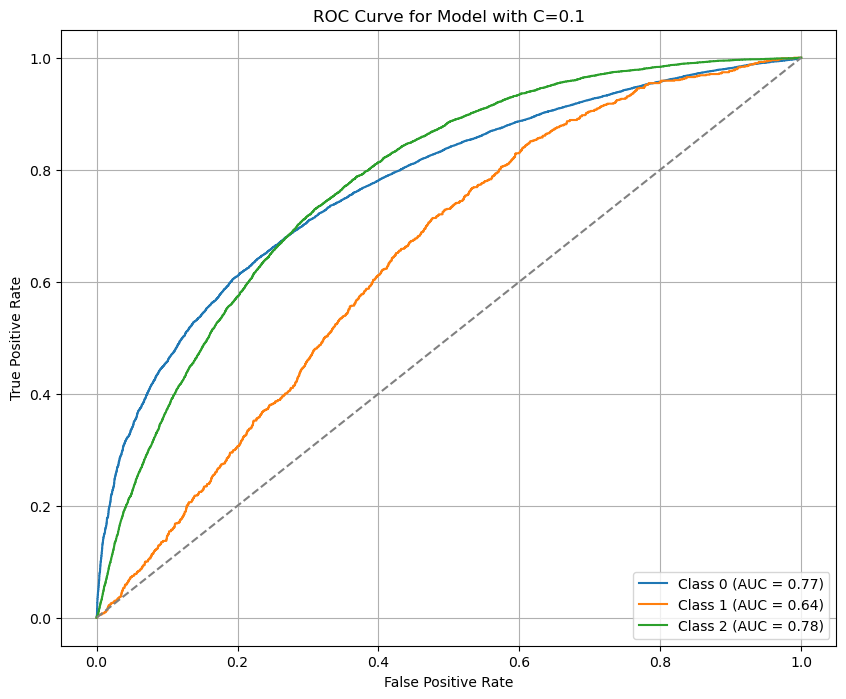

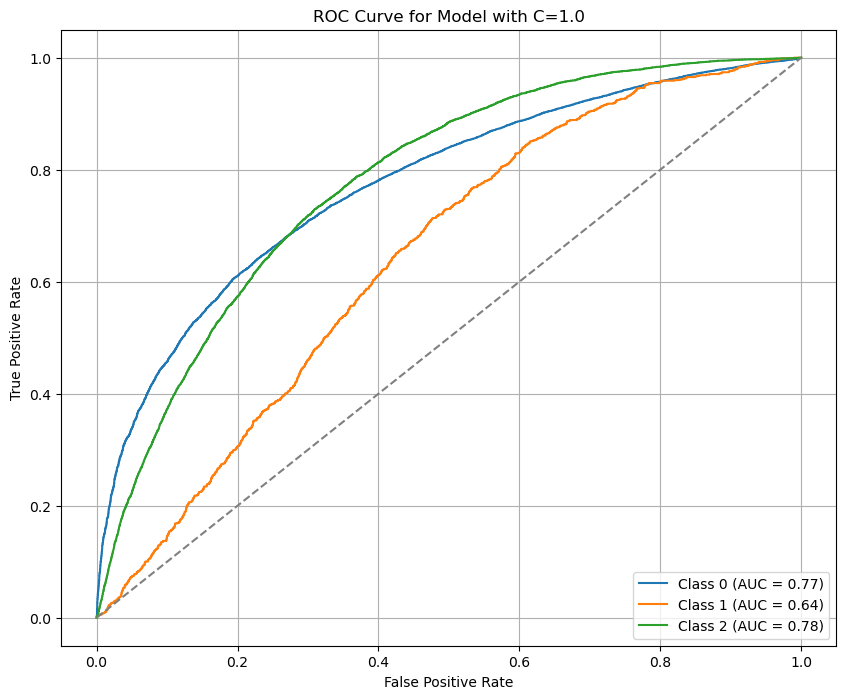

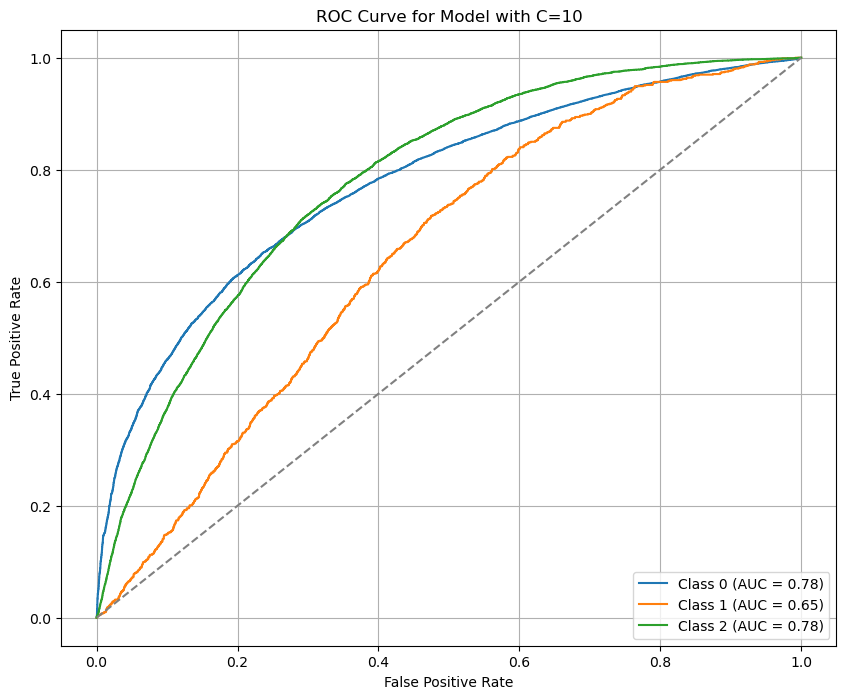

In [10]:
# SVM with Linear Kernel and One-vs-Rest strategy

# SVM with C = 1.0
svm_linear_model_c1 = CalibratedClassifierCV(OneVsRestClassifier(svm.LinearSVC(C=1, random_state=42), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)
# SVM with C = 0.1
svm_linear_model_c_1 = CalibratedClassifierCV(OneVsRestClassifier(svm.LinearSVC(C=0.1, random_state=42), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)
# SVM with C = 10
svm_linear_model_c10 = CalibratedClassifierCV(OneVsRestClassifier(svm.LinearSVC(C=10, random_state=42), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)

# Fit the SVM models for prediction
svm_linear_model_c1.fit(X_trainSampled, y_trainSampled)
svm_linear_model_c_1.fit(X_trainSampled, y_trainSampled)
svm_linear_model_c10.fit(X_trainSampled, y_trainSampled)

# Predict using the SVM models
y_predict_svm_c1 = svm_linear_model_c1.predict(X_test)
y_predict_svm_c_1 = svm_linear_model_c_1.predict(X_test)
y_predict_svm_c10 = svm_linear_model_c10.predict(X_test)

# Print reports for SVM models
print_full_report(y_test, y_predict_svm_c_1, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with C=0.1")
print_full_report(y_test, y_predict_svm_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with C=1.0")
print_full_report(y_test, y_predict_svm_c10, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with C=10")

# Predict probabilities for ROC AUC
y_predict_svm_c1_proba = svm_linear_model_c1.predict_proba(X_test)
y_predict_svm_c_1_proba = svm_linear_model_c_1.predict_proba(X_test)
y_predict_svm_c10_proba = svm_linear_model_c10.predict_proba(X_test)

# Compute ROC curve and AUC for each class for SVM models
plot_roc_curves(y_test, y_predict_svm_c_1_proba, [0, 1, 2], "ROC Curve for Model with C=0.1")
plot_roc_curves(y_test, y_predict_svm_c1_proba, [0, 1, 2], "ROC Curve for Model with C=1.0")
plot_roc_curves(y_test, y_predict_svm_c10_proba, [0, 1, 2], "ROC Curve for Model with C=10")



In [11]:
# ECOC SVM with Linear Kernel

# Create ECOC SVM models with C = 1.0, C = 0.1, and C = 0.01 and code size of 1.5
ecoc_code1_5_svm_linear_model_c1 = OutputCodeClassifier(svm.LinearSVC(C=1, random_state=42), code_size=1.5, n_jobs=-1)
ecoc_code1_5_svm_linear_model_c_1 = OutputCodeClassifier(svm.LinearSVC(C=0.1, random_state=42), code_size=1.5, n_jobs=-1)
ecoc_code1_5_svm_linear_model_c10 = OutputCodeClassifier(svm.LinearSVC(C=10, random_state=42), code_size=1.5, n_jobs=-1)

# Create ECOC SVM models with C = 1.0, C = 0.1, and C = 0.01 and code size of 0.5
ecoc_code_5_svm_linear_model_c1 = OutputCodeClassifier(svm.LinearSVC(C=1, random_state=42), code_size=0.5, n_jobs=-1)
ecoc_code_5_svm_linear_model_c_1 = OutputCodeClassifier(svm.LinearSVC(C=0.1, random_state=42), code_size=0.5, n_jobs=-1)
ecoc_code_5_svm_linear_model_c10 = OutputCodeClassifier(svm.LinearSVC(C=10, random_state=42), code_size=0.5, n_jobs=-1)

# Fit the ECOC SVM models
ecoc_code1_5_svm_linear_model_c1.fit(X_trainSampled, y_trainSampled)
ecoc_code1_5_svm_linear_model_c_1.fit(X_trainSampled, y_trainSampled)
ecoc_code1_5_svm_linear_model_c10.fit(X_trainSampled, y_trainSampled)
ecoc_code_5_svm_linear_model_c1.fit(X_trainSampled, y_trainSampled)
ecoc_code_5_svm_linear_model_c_1.fit(X_trainSampled, y_trainSampled)
ecoc_code_5_svm_linear_model_c10.fit(X_trainSampled, y_trainSampled)

# Predict using the ECOC SVM models
y_predict_ecoc_code1_5_svm_c1 = ecoc_code1_5_svm_linear_model_c1.predict(X_test)
y_predict_ecoc_code1_5_svm_c_1 = ecoc_code1_5_svm_linear_model_c_1.predict(X_test)
y_predict_ecoc_code1_5_svm_c10 = ecoc_code1_5_svm_linear_model_c10.predict(X_test)
y_predict_ecoc_code_5_svm_c1 = ecoc_code_5_svm_linear_model_c1.predict(X_test)
y_predict_ecoc_code_5_svm_c_1 = ecoc_code_5_svm_linear_model_c_1.predict(X_test)
y_predict_ecoc_code_5_svm_c10 = ecoc_code_5_svm_linear_model_c10.predict(X_test)

# Print reports for ECOC SVM models
print_full_report(y_test, y_predict_ecoc_code1_5_svm_c_1, ["No Diabetes", "Prediabetes", "Diabetes"], "ECOC SVM with C=0.1 and Code Size = 1.5")
print_full_report(y_test, y_predict_ecoc_code1_5_svm_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "ECOC SVM with C=1.0 and Code Size = 1.5")
print_full_report(y_test, y_predict_ecoc_code1_5_svm_c10, ["No Diabetes", "Prediabetes", "Diabetes"], "ECOC SVM with C=10 and Code Size = 1.5")
print_full_report(y_test, y_predict_ecoc_code_5_svm_c_1, ["No Diabetes", "Prediabetes", "Diabetes"], "ECOC SVM with C=0.1 and Code Size = 0.5")
print_full_report(y_test, y_predict_ecoc_code_5_svm_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "ECOC SVM with C=1.0 and Code Size = 0.5")
print_full_report(y_test, y_predict_ecoc_code_5_svm_c10, ["No Diabetes", "Prediabetes", "Diabetes"], "ECOC SVM with C=10 and Code Size = 0.5")


Report for Model: ECOC SVM with C=0.1 and Code Size = 1.5

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.94      0.55      0.69     38012
 Prediabetes       0.03      0.24      0.05       926
    Diabetes       0.30      0.65      0.41      7019

    accuracy                           0.56     45957
   macro avg       0.42      0.48      0.38     45957
weighted avg       0.83      0.56      0.64     45957


Confusion Matrix:
             No Diabetes  Prediabetes  Diabetes
No Diabetes        20881         7176      9955
Prediabetes          217          223       486
Diabetes            1023         1439      4557

Report for Model: ECOC SVM with C=1.0 and Code Size = 1.5

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.97      0.37      0.53     38012
 Prediabetes       0.03      0.79      0.05       926
    Diabetes       0.48      0.17      0.25      7019

    accuracy            

# SVM Modeling - Polynomial Kernel
This step is where we create SVM models using a polynomial kernel


Report for Model: SVM with Polynomial Kernel (Degree 2) and C=1.0

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.86      0.61      0.71     38012
 Prediabetes       0.02      0.25      0.04       926
    Diabetes       0.26      0.36      0.30      7019

    accuracy                           0.56     45957
   macro avg       0.38      0.40      0.35     45957
weighted avg       0.75      0.56      0.64     45957


Confusion Matrix:
             No Diabetes  Prediabetes  Diabetes
No Diabetes        23180         7821      7011
Prediabetes          469          227       230
Diabetes            3211         1314      2494

Report for Model: SVM with Polynomial Kernel (Degree 2) and C=0.1

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.86      0.74      0.80     38012
 Prediabetes       0.03      0.13      0.05       926
    Diabetes       0.26      0.33      0.29      7019

    accu

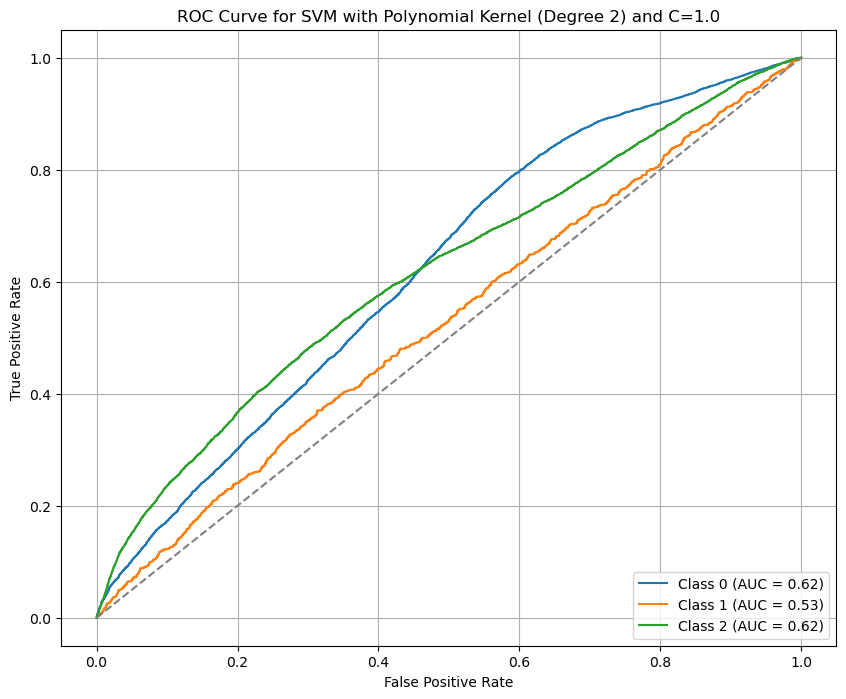

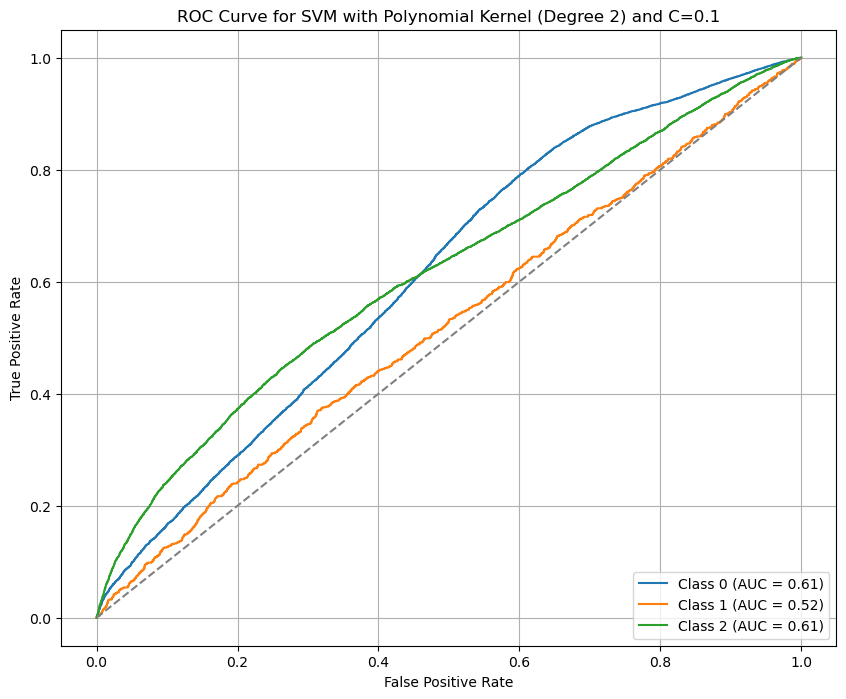

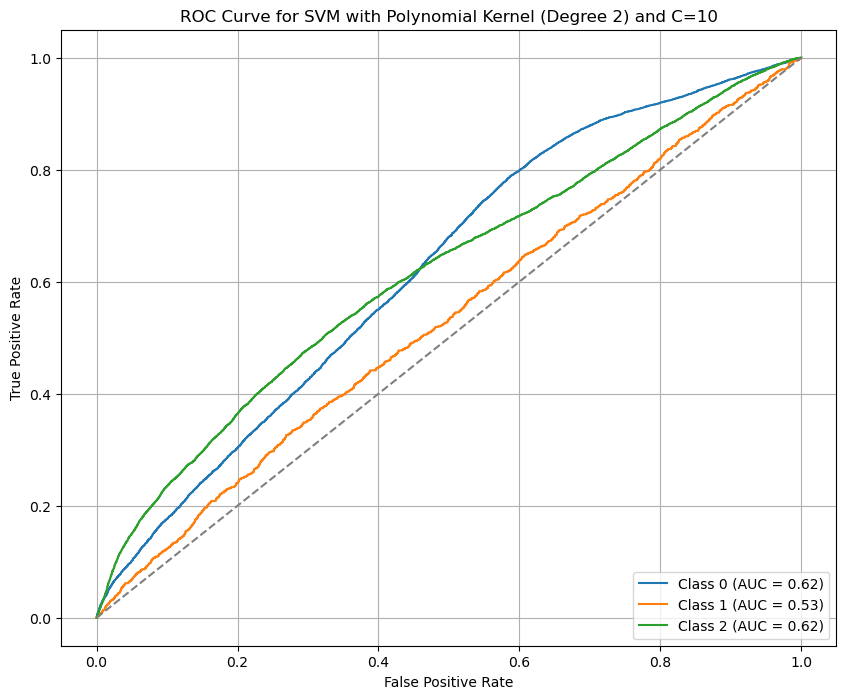

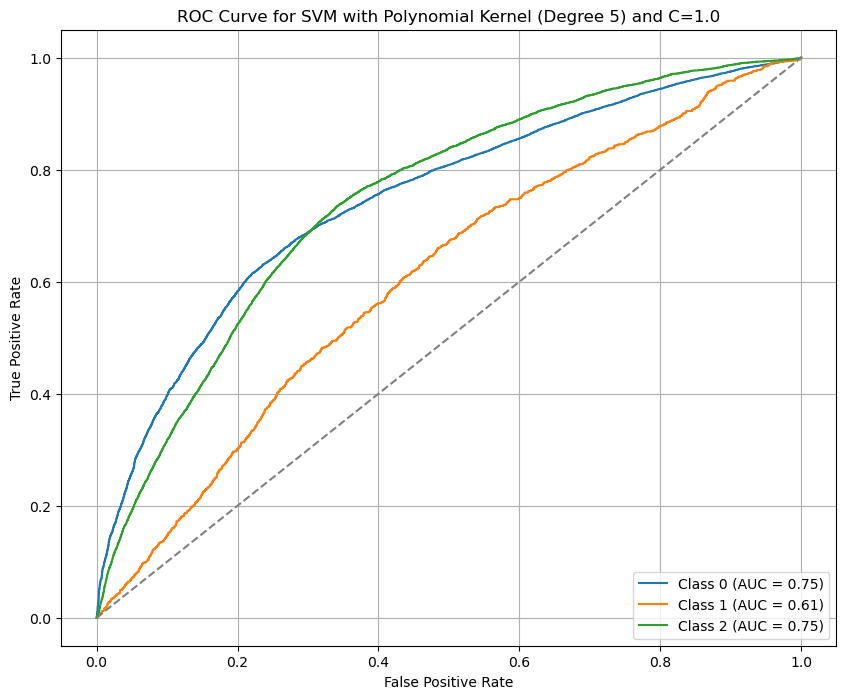

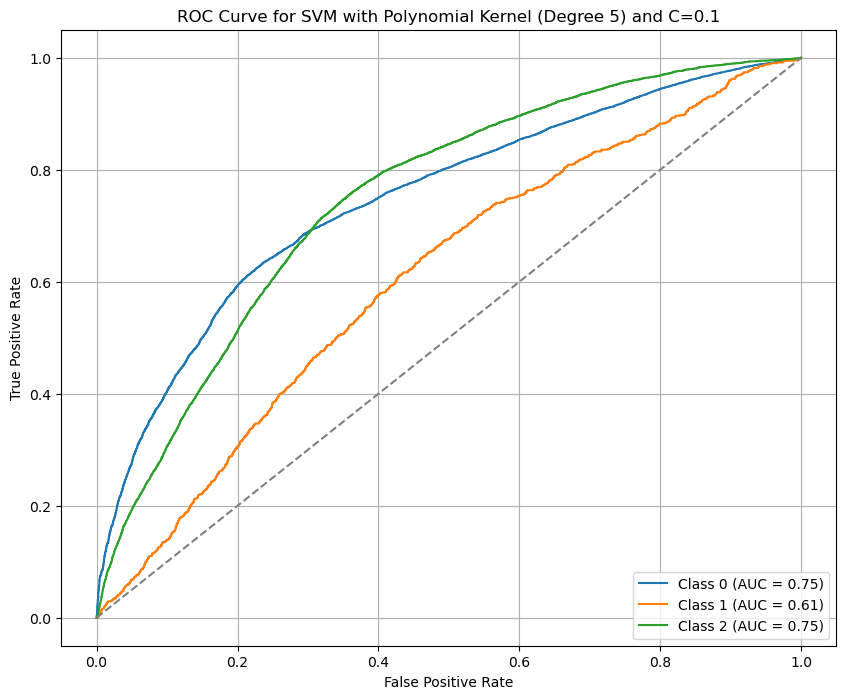

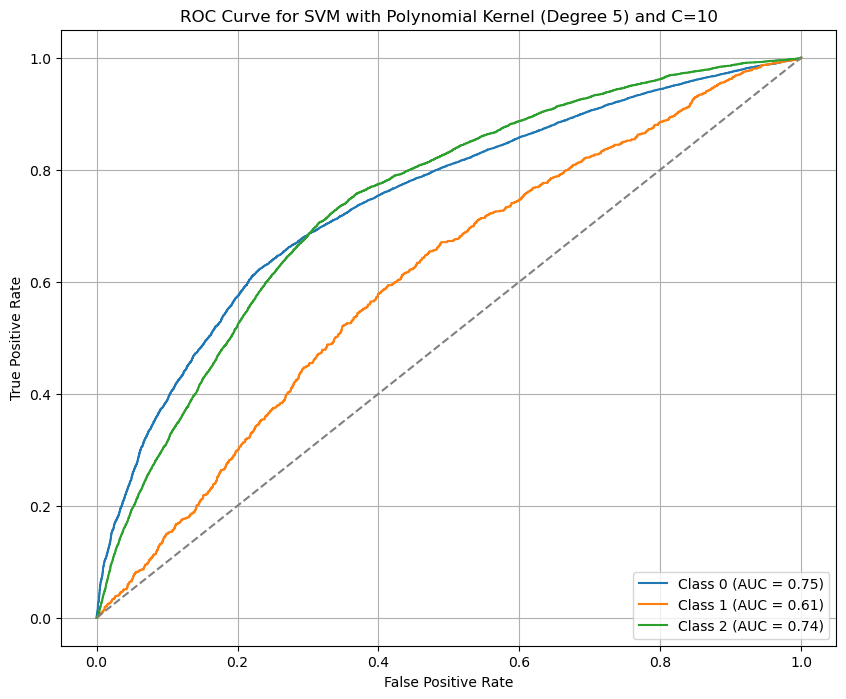

In [12]:
# SVM with polynomial kernel and One-vs-Rest strategy

# Create SVM model with polynomial kernel and degree 2 and C = 1.0, 0.1, and 10
svm_poly_2_model_c1 = CalibratedClassifierCV(OneVsRestClassifier(svm.SVC(kernel='poly', degree=2, C=1, random_state=42, class_weight='balanced'), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)
svm_poly_2_model_c_1 = CalibratedClassifierCV(OneVsRestClassifier(svm.SVC(kernel='poly', degree=2, C=0.1, random_state=42, class_weight='balanced'), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)
svm_poly_2_model_c10 = CalibratedClassifierCV(OneVsRestClassifier(svm.SVC(kernel='poly', degree=2, C=10, random_state=42, class_weight='balanced'), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)

# Create SVM model with polynomial kernel and degree 5 and C = 1.0, 0.1, and 10
svm_poly_5_model_c1 = CalibratedClassifierCV(OneVsRestClassifier(svm.SVC(kernel='poly', degree=5, C=1, random_state=42, class_weight='balanced'), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)
svm_poly_5_model_c_1 = CalibratedClassifierCV(OneVsRestClassifier(svm.SVC(kernel='poly', degree=5, C=0.1, random_state=42, class_weight='balanced'), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)
svm_poly_5_model_c10 = CalibratedClassifierCV(OneVsRestClassifier(svm.SVC(kernel='poly', degree=5, C=10, random_state=42, class_weight='balanced'), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)

# Fit the SVM model with polynomial kernal and degree 2
svm_poly_2_model_c1.fit(X_trainSampled, y_trainSampled)
svm_poly_2_model_c_1.fit(X_trainSampled, y_trainSampled)
svm_poly_2_model_c10.fit(X_trainSampled, y_trainSampled)

# Fit the SVM model with polynomial kernal and degree 5
svm_poly_5_model_c1.fit(X_trainSampled, y_trainSampled)
svm_poly_5_model_c_1.fit(X_trainSampled, y_trainSampled)
svm_poly_5_model_c10.fit(X_trainSampled, y_trainSampled)

# Predict using the SVM model with polynomial kernel and degree 2
y_predict_svm_poly_2_c1 = svm_poly_2_model_c1.predict(X_test)
y_predict_svm_poly_2_c_1 = svm_poly_2_model_c_1.predict(X_test)
y_predict_svm_poly_2_c10 = svm_poly_2_model_c10.predict(X_test)

# Predict using the SVM model with polynomial kernel and degree 5
y_predict_svm_poly_5_c1 = svm_poly_5_model_c1.predict(X_test)
y_predict_svm_poly_5_c_1 = svm_poly_5_model_c_1.predict(X_test)
y_predict_svm_poly_5_c10 = svm_poly_5_model_c10.predict(X_test)

# Print reports for SVM model with polynomial kernel and degree 2
print_full_report(y_test, y_predict_svm_poly_2_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with Polynomial Kernel (Degree 2) and C=1.0")
print_full_report(y_test, y_predict_svm_poly_2_c_1, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with Polynomial Kernel (Degree 2) and C=0.1")
print_full_report(y_test, y_predict_svm_poly_2_c10, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with Polynomial Kernel (Degree 2) and C=10")

# Print reports for SVM model with polynomial kernel and degree 5
print_full_report(y_test, y_predict_svm_poly_5_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with Polynomial Kernel (Degree 5) and C=1.0")
print_full_report(y_test, y_predict_svm_poly_5_c_1, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with Polynomial Kernel (Degree 5) and C=0.1")
print_full_report(y_test, y_predict_svm_poly_5_c10, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with Polynomial Kernel (Degree 5) and C=10")

# Predict probabilities for ROC AUC for SVM model with polynomial kernel and degree 2
y_predict_svm_poly_2_c1_proba = svm_poly_2_model_c1.predict_proba(X_test)
y_predict_svm_poly_2_c_1_proba = svm_poly_2_model_c_1.predict_proba(X_test)
y_predict_svm_poly_2_c10_proba = svm_poly_2_model_c10.predict_proba(X_test)

# Predict probabilities for ROC AUC for SVM model with polynomial kernel and degree 5
y_predict_svm_poly_5_c1_proba = svm_poly_5_model_c1.predict_proba(X_test)
y_predict_svm_poly_5_c_1_proba = svm_poly_5_model_c_1.predict_proba(X_test)
y_predict_svm_poly_5_c10_proba = svm_poly_5_model_c10.predict_proba(X_test)

# Compute ROC curve and AUC for each class for SVM model with polynomial kernel and degree 2
plot_roc_curves(y_test, y_predict_svm_poly_2_c1_proba, [0, 1, 2], "ROC Curve for SVM with Polynomial Kernel (Degree 2) and C=1.0")
plot_roc_curves(y_test, y_predict_svm_poly_2_c_1_proba, [0, 1, 2], "ROC Curve for SVM with Polynomial Kernel (Degree 2) and C=0.1")
plot_roc_curves(y_test, y_predict_svm_poly_2_c10_proba, [0, 1, 2], "ROC Curve for SVM with Polynomial Kernel (Degree 2) and C=10")

# Compute ROC curve and AUC for each class for SVM model with polynomial kernel and degree 5
plot_roc_curves(y_test, y_predict_svm_poly_5_c1_proba, [0, 1, 2], "ROC Curve for SVM with Polynomial Kernel (Degree 5) and C=1.0")
plot_roc_curves(y_test, y_predict_svm_poly_5_c_1_proba, [0, 1, 2], "ROC Curve for SVM with Polynomial Kernel (Degree 5) and C=0.1")
plot_roc_curves(y_test, y_predict_svm_poly_5_c10_proba, [0, 1, 2], "ROC Curve for SVM with Polynomial Kernel (Degree 5) and C=10")

In [13]:
# SVM with Polynomial kernal and ECOC strategy
# Create ECOC SVM model with polynomial kernel and degree 2 and C = 1.0
ecoc_poly_2_code1_5_svm_linear_model_c1 = OutputCodeClassifier(svm.SVC(kernel='poly', degree=2, C=1, random_state=42, class_weight='balanced'), code_size=1.5, n_jobs=-1)

# Create ECOC SVM model with polynomial kernel and degree 3 and C = 1.0
ecoc_poly_5_code1_5_svm_linear_model_c1 = OutputCodeClassifier(svm.SVC(kernel='poly', degree=5, C=1, random_state=42, class_weight='balanced'), code_size=1.5, n_jobs=-1)

# Fit the ECOC SVM model with polynomial kernel and degree 2
ecoc_poly_2_code1_5_svm_linear_model_c1.fit(X_trainSampled, y_trainSampled)

# Fit the ECOC SVM model with polynomial kernel and degree 3
ecoc_poly_5_code1_5_svm_linear_model_c1.fit(X_trainSampled, y_trainSampled)

# Predict using the ECOC SVM model with polynomial kernel and degree 2
y_predict_ecoc_poly_2_code1_5_svm_c1 = ecoc_poly_2_code1_5_svm_linear_model_c1.predict(X_test)


# Predict using the ECOC SVM model with polynomial kernel and degree 3
y_predict_ecoc_poly_5_code1_5_svm_c1 = ecoc_poly_5_code1_5_svm_linear_model_c1.predict(X_test)

# Print reports for ECOC SVM model with polynomial kernel and degree 2
print_full_report(y_test, y_predict_ecoc_poly_2_code1_5_svm_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "ECOC SVM with Polynomial Kernel (Degree 2) and C=1.0")

# Print reports for ECOC SVM model with polynomial kernel and degree 3
print_full_report(y_test, y_predict_ecoc_poly_5_code1_5_svm_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "ECOC SVM with Polynomial Kernel (Degree 3) and C=1.0")


Report for Model: ECOC SVM with Polynomial Kernel (Degree 2) and C=1.0

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.86      0.84      0.85     38012
 Prediabetes       0.03      0.12      0.05       926
    Diabetes       0.32      0.22      0.26      7019

    accuracy                           0.73     45957
   macro avg       0.40      0.39      0.38     45957
weighted avg       0.76      0.73      0.74     45957


Confusion Matrix:
             No Diabetes  Prediabetes  Diabetes
No Diabetes        31997         2900      3115
Prediabetes          679          113       134
Diabetes            4645          857      1517

Report for Model: ECOC SVM with Polynomial Kernel (Degree 3) and C=1.0

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.88      0.82      0.85     38012
 Prediabetes       0.03      0.18      0.06       926
    Diabetes       0.36      0.29      0.33      7019

# SVM Modeling - RBF Kernel
This step is where we use SVM with the rbf kernel


Report for Model: SVM with RBF Kernel (Gamma = 0.001) and C=1.0

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.92      0.67      0.78     38012
 Prediabetes       0.03      0.15      0.04       926
    Diabetes       0.33      0.61      0.43      7019

    accuracy                           0.65     45957
   macro avg       0.43      0.48      0.42     45957
weighted avg       0.81      0.65      0.71     45957


Confusion Matrix:
             No Diabetes  Prediabetes  Diabetes
No Diabetes        25626         4110      8276
Prediabetes          355          139       432
Diabetes            1767         1003      4249

Report for Model: SVM with RBF Kernel (Gamma = 0.01) and C=1.0

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.93      0.65      0.77     38012
 Prediabetes       0.03      0.21      0.05       926
    Diabetes       0.33      0.58      0.42      7019

    accuracy 

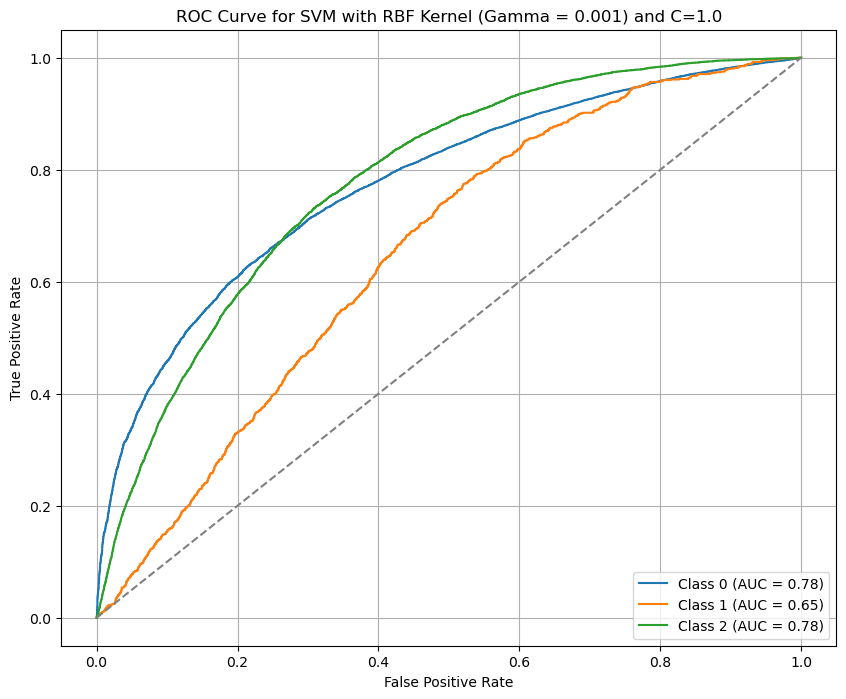

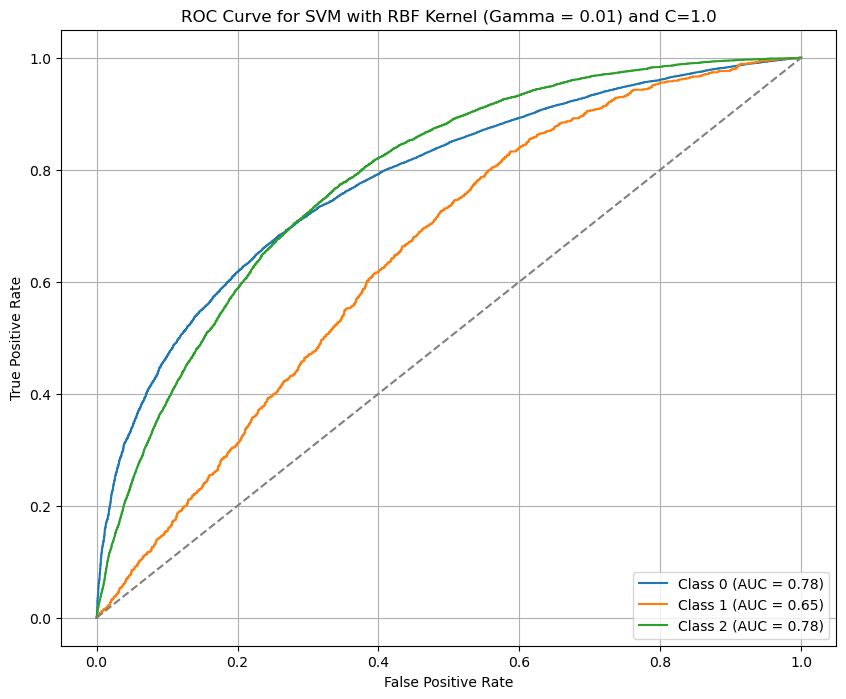

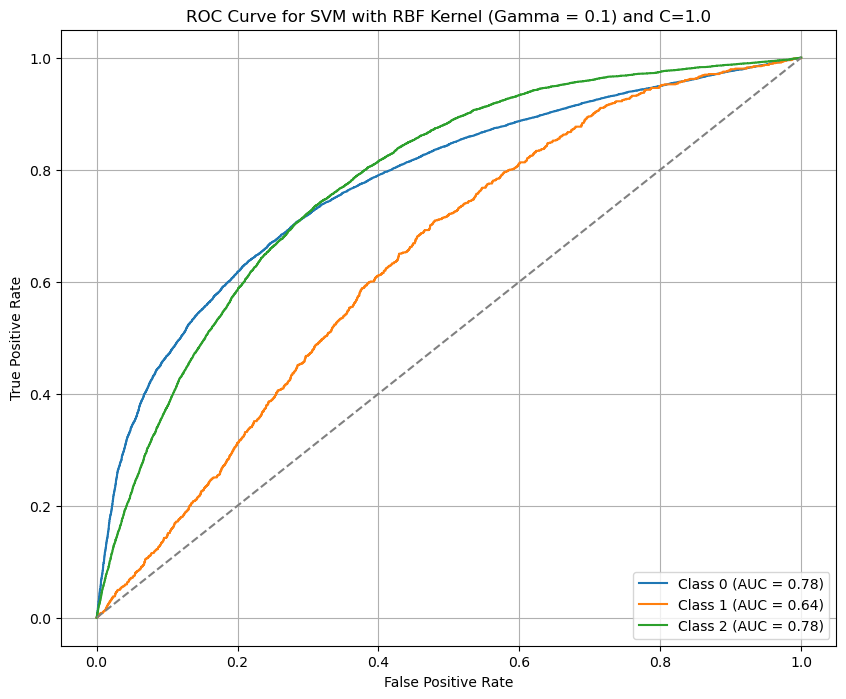

In [14]:
# SVM with RBF kernel and One-vs-Rest strategy
# Create SVM model with RBF kernel and gamma = 0.001 and C = 1.0
svm_rbf_g__1_model_c1 = CalibratedClassifierCV(OneVsRestClassifier(svm.SVC(kernel='rbf', gamma=0.001, C=1, random_state=42, class_weight='balanced'), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)

# Create SVM model with RBF kernel and gamma = 0.01 and C = 1.0
svm_rbf_g_1_model_c1 = CalibratedClassifierCV(OneVsRestClassifier(svm.SVC(kernel='rbf', gamma=0.01, C=1, random_state=42, class_weight='balanced'), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)

# Create SVM model with RBF kernel and gamma = 0.1 and C = 1.0
svm_rbf_g1_model_c1 = CalibratedClassifierCV(OneVsRestClassifier(svm.SVC(kernel='rbf', gamma=0.1, C=1, random_state=42, class_weight='balanced'), n_jobs=-1), cv=5, method='sigmoid', n_jobs=-1)

# Fit the SVM model with RBF kernel and gamma = 0.001
svm_rbf_g__1_model_c1.fit(X_trainSampled, y_trainSampled)

# Fit the SVM model with RBF kernel and gamma = 0.01
svm_rbf_g_1_model_c1.fit(X_trainSampled, y_trainSampled)

# Fit the SVM model with RBF kernel and gamma = 0.1
svm_rbf_g1_model_c1.fit(X_trainSampled, y_trainSampled)

# Predict using the SVM model with RBF kernel and gamma = 0.001
y_predict_svm_rbf_g__1_c1 = svm_rbf_g__1_model_c1.predict(X_test)

# Predict using the SVM model with RBF kernel and gamma = 0.01
y_predict_svm_rbf_g_1_c1 = svm_rbf_g_1_model_c1.predict(X_test)

# Predict using the SVM model with RBF kernel and gamma = 0.1
y_predict_svm_rbf_g1_c1 = svm_rbf_g1_model_c1.predict(X_test)

# Print reports for SVM model with RBF kernel and gamma = 0.001
print_full_report(y_test, y_predict_svm_rbf_g__1_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with RBF Kernel (Gamma = 0.001) and C=1.0")

# Print reports for SVM model with RBF kernel and gamma = 0.01
print_full_report(y_test, y_predict_svm_rbf_g_1_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with RBF Kernel (Gamma = 0.01) and C=1.0")

# Print reports for SVM model with RBF kernel and gamma = 0.1
print_full_report(y_test, y_predict_svm_rbf_g1_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "SVM with RBF Kernel (Gamma = 0.1) and C=1.0")

# Predict probabilities for ROC AUC for SVM model with RBF kernel and gamma = 0.001
y_predict_svm_rbf_g__1_c1_proba = svm_rbf_g__1_model_c1.predict_proba(X_test)

# Predict probabilities for ROC AUC for SVM model with RBF kernel and gamma = 0.01
y_predict_svm_rbf_g_1_c1_proba = svm_rbf_g_1_model_c1.predict_proba(X_test)

# Predict probabilities for ROC AUC for SVM model with RBF kernel and gamma = 0.1
y_predict_svm_rbf_g1_c1_proba = svm_rbf_g1_model_c1.predict_proba(X_test)

# Compute ROC curve and AUC for each class for SVM model with RBF kernel and gamma = 0.001
plot_roc_curves(y_test, y_predict_svm_rbf_g__1_c1_proba, [0, 1, 2], "ROC Curve for SVM with RBF Kernel (Gamma = 0.001) and C=1.0")

# Compute ROC curve and AUC for each class for SVM model with RBF kernel and gamma = 0.01
plot_roc_curves(y_test, y_predict_svm_rbf_g_1_c1_proba, [0, 1, 2], "ROC Curve for SVM with RBF Kernel (Gamma = 0.01) and C=1.0")

# Compute ROC curve and AUC for each class for SVM model with RBF kernel and gamma = 0.1
plot_roc_curves(y_test, y_predict_svm_rbf_g1_c1_proba, [0, 1, 2], "ROC Curve for SVM with RBF Kernel (Gamma = 0.1) and C=1.0")

In [15]:
# SVM with RBF kernel and ECOC strategy

# Create ECOC SVM model with RBF kernel and gamma = 0.001 and C = 1.0
ecoc_rbf_g__1_code1_5_svm_model_c1 = OutputCodeClassifier(svm.SVC(kernel='rbf', gamma=0.001, C=1, random_state=42, class_weight='balanced'), code_size=1.5, n_jobs=-1)

# Create ECOC SVM model with RBF kernel and gamma = 0.01 and C = 1.0
ecoc_rbf_g_1_code1_5_svm_model_c1 = OutputCodeClassifier(svm.SVC(kernel='rbf', gamma=0.01, C=1, random_state=42, class_weight='balanced'), code_size=1.5, n_jobs=-1)

# Create ECOC SVM model with RBF kernel and gamma = 0.1 and C = 1.0
ecoc_rbf_g1_code1_5_svm_model_c1 = OutputCodeClassifier(svm.SVC(kernel='rbf', gamma=0.1, C=1, random_state=42, class_weight='balanced'), code_size=1.5, n_jobs=-1)

# Fit the ECOC SVM model with RBF kernel and gamma = 0.001
ecoc_rbf_g__1_code1_5_svm_model_c1.fit(X_trainSampled, y_trainSampled)

# Fit the ECOC SVM model with RBF kernel and gamma = 0.01
ecoc_rbf_g_1_code1_5_svm_model_c1.fit(X_trainSampled, y_trainSampled)

# Fit the ECOC SVM model with RBF kernel and gamma = 0.1
ecoc_rbf_g1_code1_5_svm_model_c1.fit(X_trainSampled, y_trainSampled)

# Predict using the ECOC SVM model with RBF kernel and gamma = 0.001
y_predict_ecoc_rbf_g__1_code1_5_svm_c1 = ecoc_rbf_g__1_code1_5_svm_model_c1.predict(X_test)

# Predict using the ECOC SVM model with RBF kernel and gamma = 0.01
y_predict_ecoc_rbf_g_1_code1_5_svm_c1 = ecoc_rbf_g_1_code1_5_svm_model_c1.predict(X_test)

# Predict using the ECOC SVM model with RBF kernel and gamma = 0.1
y_predict_ecoc_rbf_g1_code1_5_svm_c1 = ecoc_rbf_g1_code1_5_svm_model_c1.predict(X_test)

# Print reports for ECOC SVM model with RBF kernel and gamma = 0.001
print_full_report(y_test, y_predict_ecoc_rbf_g__1_code1_5_svm_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "ECOC SVM with RBF Kernel (Gamma = 0.001) and C=1.0")

# Print reports for ECOC SVM model with RBF kernel and gamma = 0.01
print_full_report(y_test, y_predict_ecoc_rbf_g_1_code1_5_svm_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "ECOC SVM with RBF Kernel (Gamma = 0.01) and C=1.0")

# Print reports for ECOC SVM model with RBF kernel and gamma = 0.1
print_full_report(y_test, y_predict_ecoc_rbf_g1_code1_5_svm_c1, ["No Diabetes", "Prediabetes", "Diabetes"], "ECOC SVM with RBF Kernel (Gamma = 0.1) and C=1.0")


Report for Model: ECOC SVM with RBF Kernel (Gamma = 0.001) and C=1.0

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.91      0.73      0.81     38012
 Prediabetes       0.00      0.00      0.00       926
    Diabetes       0.31      0.69      0.43      7019

    accuracy                           0.71     45957
   macro avg       0.41      0.47      0.41     45957
weighted avg       0.80      0.71      0.74     45957


Confusion Matrix:
             No Diabetes  Prediabetes  Diabetes
No Diabetes        27672            0     10340
Prediabetes          420            0       506
Diabetes            2152            0      4867

Report for Model: ECOC SVM with RBF Kernel (Gamma = 0.01) and C=1.0

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.92      0.72      0.81     38012
 Prediabetes       0.00      0.00      0.00       926
    Diabetes       0.31      0.71      0.43      7019

   

# SVM Modeling - All Together
All the different SVM types together for ease of future use

In [16]:
# Linear, Polynomial, and RBF SVM with ECOC strategy using GridSearchCV

params = [
    {"kernel": ["linear"], "C": [1, 0.1, 10]},
    {"kernel": ["poly"], "degree": [2, 5], "C": [1, 0.1, 10]},
    {"kernel": ["rbf"], "gamma": [0.001, 0.01, 0.1], "C": [1, 0.1, 10]},
]

# Base SVM model
svc = svm.SVC()

# Create a GridSearchCV object with the SVM model and parameter grid
model = GridSearchCV(svc, params, cv=5, n_jobs=-1)
model = OutputCodeClassifier(model, code_size=1.5, n_jobs=-1)
model.fit(X_trainSampled, y_trainSampled)

# Predict using the best estimator
y_predict_best = model.predict(X_test)

# Print report for the best estimator
print("\nBest Estimator Report:")
print(model._estimator_type)
print_full_report(y_test, y_predict_best, ["No Diabetes", "Prediabetes", "Diabetes"], "Best SVM Model from Grid Search")
print("\nScore:", model.score(X_test, y_test))


Best Estimator Report:
classifier

Report for Model: Best SVM Model from Grid Search

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.84      0.98      0.91     38012
 Prediabetes       0.00      0.00      0.00       926
    Diabetes       0.51      0.13      0.20      7019

    accuracy                           0.83     45957
   macro avg       0.45      0.37      0.37     45957
weighted avg       0.77      0.83      0.78     45957


Confusion Matrix:
             No Diabetes  Prediabetes  Diabetes
No Diabetes        37231            0       781
Prediabetes          858            0        68
Diabetes            6130            0       889

Score: 0.829471027264617


# SVM Modeling - One Class
In this section we create a different SVM RBF model for each Class and then combine them to predict the entire population

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.50      0.63     38012
           1       0.03      0.13      0.05       926
           2       0.39      0.04      0.07      7019

   micro avg       0.74      0.42      0.54     45957
   macro avg       0.43      0.22      0.25     45957
weighted avg       0.78      0.42      0.53     45957



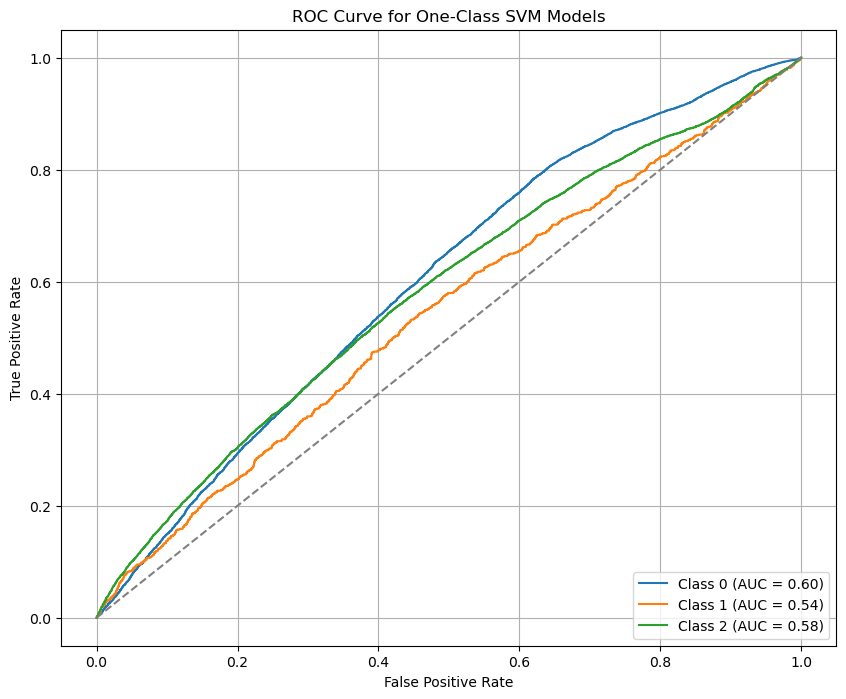

In [17]:
# One Class SVM for each class using
class_0_data = X_trainSampled[y_trainSampled == 0]
class_1_data = X_trainSampled[y_trainSampled == 1]
class_2_data = X_trainSampled[y_trainSampled == 2]


# Initialize One-Class SVM models
ocsvm_class_0 = svm.OneClassSVM(kernel='rbf')
ocsvm_class_1 = svm.OneClassSVM(kernel='rbf')
ocsvm_class_2 = svm.OneClassSVM(kernel='rbf')

# Train the models on their respective class data
ocsvm_class_0.fit(class_0_data)
ocsvm_class_1.fit(class_1_data)
ocsvm_class_2.fit(class_2_data)

# Predict on the test set for each model
y_pred_class_0 = ocsvm_class_0.predict(X_test)
y_pred_class_1 = ocsvm_class_1.predict(X_test)
y_pred_class_2 = ocsvm_class_2.predict(X_test)

y_pred_class_0_prob = ocsvm_class_0.decision_function(X_test)
y_pred_class_1_prob = ocsvm_class_1.decision_function(X_test)
y_pred_class_2_prob = ocsvm_class_2.decision_function(X_test)


# Map One-Class SVM predictions to class labels
y_pred_combined = []

for i in range(len(X_test)):
    if y_pred_class_0[i] == 1:
        y_pred_combined.append(0)  # Class 0
    elif y_pred_class_1[i] == 1:
        y_pred_combined.append(1)  # Class 1
    elif y_pred_class_2[i] == 1:
        y_pred_combined.append(2)  # Class 2
    else:
        y_pred_combined.append(-1)  # Unknown or rejected class

# Convert to numpy array for compatibility
y_pred_combined = np.array(y_pred_combined)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_combined, labels=[0, 1, 2], zero_division=0))

# Combine the decision function outputs into a single array
y_prob = np.vstack([y_pred_class_0_prob, y_pred_class_1_prob, y_pred_class_2_prob]).T

# Define the class labels
classes = [0, 1, 2]

# Call the helper function to plot the ROC curves
plot_roc_curves(y_test, y_prob, classes, title="ROC Curve for One-Class SVM Models")

